In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import texttable
import sys
sys.path.append("../src")
from data_proc import *
from policy import *
from simulate import *
from util import Progbar

pd.options.mode.chained_assignment = None

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

In [3]:
DATA_PATH = "../data/warfarin.csv"  # path to raw Warfarin data file

In [15]:
def evaluate_risk(simulator, policies, num_runs=100):
    """
    Simulates a list of policies, each for 'num_runs' times (using the same sets of random permutations);
    and compares the policies' regret & "risk":
    
    We judge a policy's risk based on how often it chooses low (high) when the optimal decision is high (low)
    
    simulator:
        WarfarinSimulator instance
    policies:
        List of (Policy, string) tuples, where the string is a description of the policy
        The Policy instances should implement reset(), choose_arm(), and update_policy()
    """
    train_size = simulator.train_size  # number of online learning steps
    
    # record simulation results
    header = ['Policy', 'Mean', 'Std', 'Max', 'Min']
    table_regret = texttable.Texttable()
    table_regret.header(header)
    table_risk = texttable.Texttable()
    table_risk.header(header)
    
    regret_list = []
    risk_list = []
    
    base_seed = np.random.randint(1000)  # randomizing dataset permutations
    for policy, policy_name in policies:
        print("Start simulating {}".format(policy_name))
    
        regrets = []  # total regrets
        risk_percent = []  # percentage of severe mistakes (low->high or high->low)
        progbar = Progbar(num_runs)  # progress bar
        for i in range(num_runs):
            policy.reset()  # Reset the policy to its initial states            
            simulator.simulate(policy, eval_every=10000, random_seed=(base_seed+i))
            regrets.append(simulator.get_total_regret())
            confusion_matrix = simulator.get_confusion_matrix()
            risk_percent.append((confusion_matrix[0,2] + confusion_matrix[2,0]) / train_size * 100)
            progbar.update(i+1)

        table_regret.add_row((policy_name, np.mean(regrets), np.std(regrets),
                              np.max(regrets), np.min(regrets)))
        table_risk.add_row((policy_name, np.mean(risk_percent), np.std(risk_percent),
                            np.max(risk_percent), np.min(risk_percent)))
        
        regret_list.append(np.mean(regrets))
        risk_list.append(np.mean(risk_percent))
    
    print("Regret Statistics:")
    print(table_regret.draw())
    print("Risk Statistics (Percentage of high->low & low->high decisions):")
    print(table_risk.draw())
    
    return regret_list, risk_list

# simulator = WarfarinSimulator(DATA_PATH, discretize_label_3, test_size=500, add_bias=True)
# num_features = simulator.num_features
# num_arms = simulator.num_arms

# evaluate_risk(simulator, [
#     (WarfarinLinearOraclePolicy(DATA_PATH, discretize_label_3), "LinearOracle"),
#     (LinUCBPolicy(num_features, num_arms, alpha=1.0), "LinUCB"),
#     (LinUCBSafePolicy(num_features, num_arms, alpha=1.0), "LinUCBSafe"),
#     (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0), "Greedy"),
#     (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda t: 0.2-t/20000), "EpsDecay"),
#     (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0.2), "EpsGreedy(0.2)"),
#     (WarfarinFixedDosePolicy(1), "Fixed-dose"),
# ], num_runs=500)

In [77]:
simulator = WarfarinSimulator(DATA_PATH, discretize_label_3, test_size=500, add_bias=True)
num_features = simulator.num_features
num_arms = simulator.num_arms
# alpha = np.logspace(-1, 1, 16, endpoint=True)
alpha = [0.1, 0.4, 0.7, 1.0, 3.0, 5.0, 8.0, 10.0]
regret_matrix, risk_matrix = [], []

for a in alpha:
    regret_list, risk_list = evaluate_risk(simulator, [
        (WarfarinLinearOraclePolicy(DATA_PATH, discretize_label_3), "LinearOracle"),
        (LinUCBPolicy(num_features, num_arms, alpha=a), "LinUCB"),
#         (LinUCBSafePolicy(num_features, num_arms, alpha=1.0), "LinUCBSafe"),
        (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0), "Greedy"),
#         (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda t: 0.2-t/20000), "EpsDecay"),
#         (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0.2), "EpsGreedy(0.2)"),
#         (WarfarinFixedDosePolicy(1), "Fixed-dose"),
    ], num_runs=400)
    regret_matrix.append(regret_list)
    risk_matrix.append(risk_list)

Instantiated a Warfarin Bandit simulator!
Reward structure: binary
Number of arms: 3
Number of features: 24
Size of training set for online learning: 5028
Size of holdout validation set: 500
Start simulating LinearOracle
400/400 [==============================] - 15s    
Start simulating LinUCB
400/400 [==============================] - 115s   
Start simulating Greedy
400/400 [==============================] - 94s    
Regret Statistics:
+--------------+----------+--------+------+------+
|    Policy    |   Mean   |  Std   | Max  | Min  |
+==============+==========+========+======+======+
| LinearOracle | 1653.707 | 10.433 | 1686 | 1622 |
+--------------+----------+--------+------+------+
| LinUCB       | 1734.625 | 31.913 | 1883 | 1655 |
+--------------+----------+--------+------+------+
| Greedy       | 1740.037 | 30.566 | 1869 | 1672 |
+--------------+----------+--------+------+------+
Risk Statistics (Percentage of high->low & low->high decisions):
+--------------+-------+-------+---

400/400 [==============================] - 16s    
Start simulating LinUCB
400/400 [==============================] - 124s   
Start simulating Greedy
400/400 [==============================] - 97s    
Regret Statistics:
+--------------+----------+--------+------+------+
|    Policy    |   Mean   |  Std   | Max  | Min  |
+==============+==========+========+======+======+
| LinearOracle | 1653.322 | 10.094 | 1690 | 1629 |
+--------------+----------+--------+------+------+
| LinUCB       | 2205.240 | 23.719 | 2273 | 2137 |
+--------------+----------+--------+------+------+
| Greedy       | 1739.475 | 30.189 | 1887 | 1666 |
+--------------+----------+--------+------+------+
Risk Statistics (Percentage of high->low & low->high decisions):
+--------------+-------+-------+-------+-------+
|    Policy    | Mean  |  Std  |  Max  |  Min  |
+==============+=======+=======+=======+=======+
| LinearOracle | 0.180 | 0.019 | 0.199 | 0.099 |
+--------------+-------+-------+-------+-------+
| LinUCB   

In [78]:
print (regret_matrix)
print (risk_matrix)

[[1653.7075, 1734.625, 1740.0375], [1653.705, 1727.84, 1739.9525], [1654.145, 1726.725, 1739.63], [1653.3325, 1732.5775, 1740.0275], [1654.0875, 1828.205, 1739.6925], [1654.04, 1946.0575, 1740.7825], [1653.655, 2105.9, 1740.9625], [1653.3225, 2205.24, 1739.475]]
[[0.18163285600636436, 0.6373806682577566, 0.6004872712808274], [0.1798428798727128, 0.7493038981702466, 0.6075974542561654], [0.18217979315831342, 0.8542661097852027, 0.6001392203659506], [0.1803898170246619, 0.9690731901352426, 0.6117243436754176], [0.18217979315831342, 1.6958035003977725, 0.6030230708035004], [0.1796439936356404, 2.403639618138425, 0.5962112171837709], [0.1798428798727128, 3.3490950676213207, 0.6056583134447097], [0.1796439936356404, 3.9493337311058077, 0.6085918854415274]]


In [88]:
def plot_helper(regret_matrix, risk_matrix, alpha):
    plt.figure()
    
    for i in range(len(regret_matrix[0])):
#         plt.plot(alpha,regret_matrix[:,i])
        plt.plot(alpha,risk_matrix[:,i])
    
    plt.legend(["LinearOracle","LinUCB","Greedy"])
    plt.title("Risk vs Alpha")    
    plt.show()

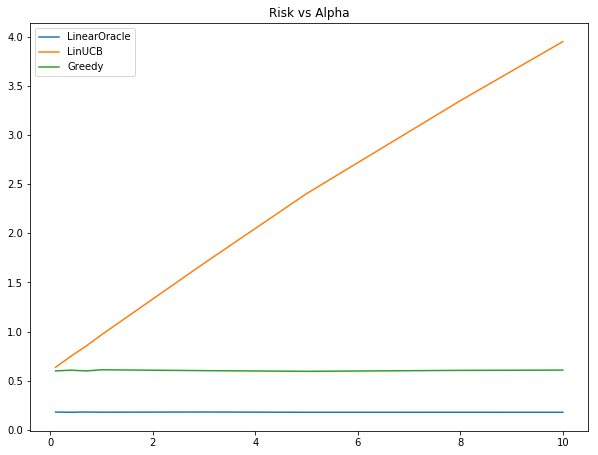

In [89]:
# alpha -> 400~500
# linUCB, oracle, greedy
# thompson sampling
# plot risk vs alpha, regret vs alpha
# alpha [0.1,10]
# algo linusbsafe
# reward

regret_matrix = np.array(regret_matrix)
risk_matrix = np.array(risk_matrix)
plot_helper(regret_matrix, risk_matrix, alpha)


In [82]:
alpha = [0.1, 0.4, 0.7, 1.0, 3.0, 5.0, 8.0, 10.0]